# 房價預測



- 來源：[Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview)
- 目標：SalePrice 房價（美金）


In [5]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt 
import seaborn as sns
import random
import os
from scipy import stats
from scipy.stats import norm, skew 

plt.rc("font",family="SimHei",size="15") 

%matplotlib inline 

In [6]:
df_train = pd.read_csv("data2/train.csv")
df_test = pd.read_csv('data2/test.csv')

df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [8]:

df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans.


<Figure size 1600x500 with 0 Axes>

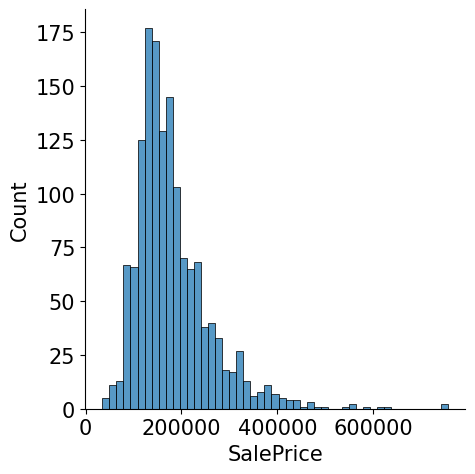

In [9]:
plt.figure(figsize=(16, 5))
sns.displot(df_train['SalePrice'],kde=False)  

In [10]:
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


<AxesSubplot:>

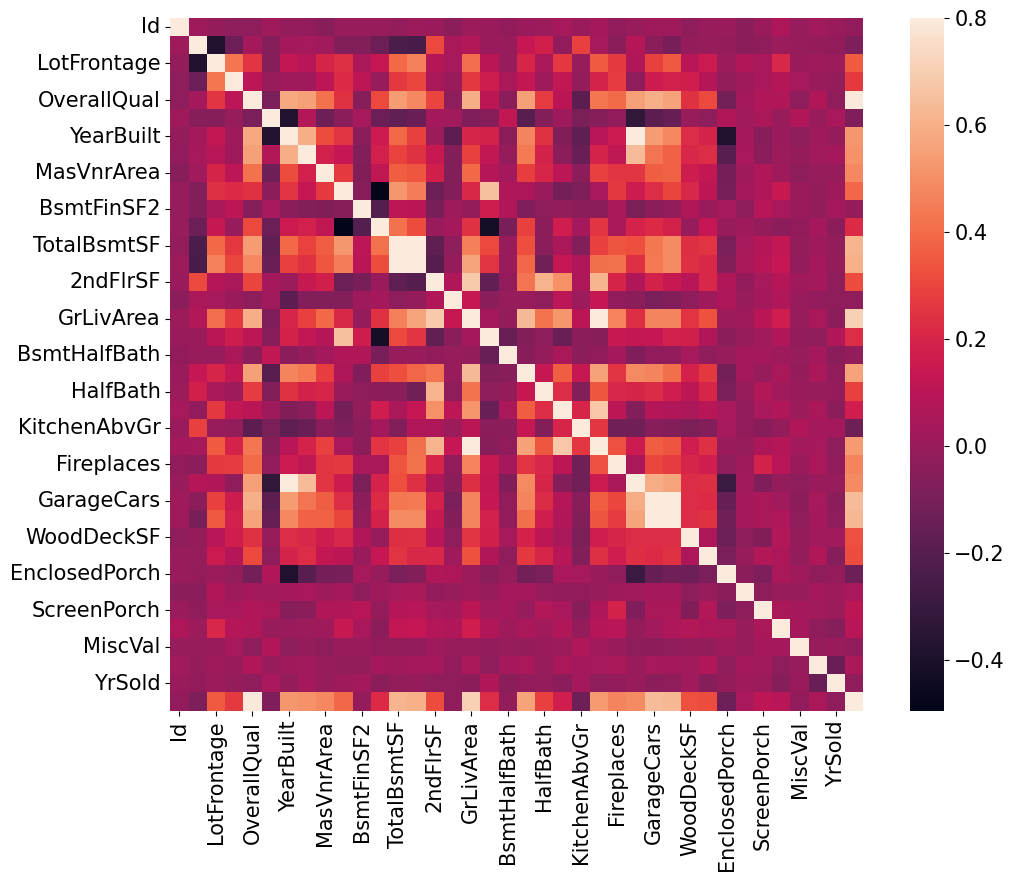

In [11]:
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

In [74]:
print(df_train["SalePrice"])

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64


# Impute and Preprocessing

In [12]:
def missing(data,num=10):
    null_data = data.isnull().sum().sort_values(ascending=False)
    percent_1 = data.isnull().sum()/data.isnull().count()
    missing_data = pd.concat([null_data,percent_1.apply(lambda x: format(x, '.2%'))],axis=1,keys=['total missing','missing percentage'])
    print(missing_data.head(num))

missing(df_train, 15)


              total missing missing percentage
PoolQC                 1453             99.52%
MiscFeature            1406             96.30%
Alley                  1369             93.77%
Fence                  1179             80.75%
FireplaceQu             690             47.26%
LotFrontage             259             17.74%
GarageYrBlt              81              5.55%
GarageCond               81              5.55%
GarageType               81              5.55%
GarageFinish             81              5.55%
GarageQual               81              5.55%
BsmtFinType2             38              2.60%
BsmtExposure             38              2.60%
BsmtQual                 37              2.53%
BsmtCond                 37              2.53%


In [13]:
df_train.drop(["PoolQC","MiscFeature","Alley","Fence"], axis=1, inplace=True)
missing(df_train,5) 


              total missing missing percentage
FireplaceQu             690             47.26%
LotFrontage             259             17.74%
GarageType               81              5.55%
GarageYrBlt              81              5.55%
GarageFinish             81              5.55%


In [14]:
numeric = df_train.dtypes[df_train.dtypes == "int64"]
object_ = df_train.dtypes[df_train.dtypes == "object"]

In [15]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 77 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

df_train['LotShape'] = df_train['LotShape'].replace(['Reg', 'IR1', 'IR2', 'IR3'], [0,1,2,3])
df_train['LandContour'] = df_train['LandContour'].replace( ['Lvl', 'Bnk', 'Low', 'HLS'],[0,1,-1,2])
df_train['Street'] = df_train['Street'].replace(['Pave', 'Grvl'], [0,1])
df_train['MSZoning'] = df_train['MSZoning'].replace(['RL', 'RM', 'C (all)', 'FV', 'RH'], [2,1,0,3,1])
df_train.drop("Utilities",axis = 1, inplace = True)
df_train['LotConfig'] = df_train['LotConfig'].replace(['Inside', 'FR2', 'Corner', 'CulDSac', 'FR3'], [0,0,0,1,1])
df_train['MSZoning'] = df_train['MSZoning'].replace(['RL', 'RM', 'C (all)', 'FV', 'RH'], [2,1,0,3,1])

###太多了寫不完

In [16]:
def check_Cate_mean_price(col):
    ele = list(df_train[col].unique())
    print(df_train[col] .value_counts())
    print()
    for j in ele :
        print(j,np.mean([df_train["SalePrice"][i] for i in range(1460) if df_train[col][i] == j]))
    
    return ele


col = "LotConfig"
check_Cate_mean_price(col)


Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64

Inside 176938.0475285171
FR2 177934.5744680851
Corner 181623.4258555133
CulDSac 223854.6170212766
FR3 208475.0


['Inside', 'FR2', 'Corner', 'CulDSac', 'FR3']

In [17]:
df_train['MSSubClass'] = df_train['MSSubClass'].apply(str)
df_train['OverallCond'] = df_train['OverallCond'].astype(str)
df_train['YrSold'] = df_train['YrSold'].astype(str)
df_train['MoSold'] = df_train['MoSold'].astype(str)

In [18]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond',
        'ExterQual', 'ExterCond','HeatingQC',  'KitchenQual', 'BsmtFinType1',
        'BsmtFinType2', 'Functional',  'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street',  'CentralAir', 'MSSubClass', 'OverallCond',
        'YrSold', 'MoSold')

for c in cols:
    lbl = LabelEncoder()
    lbl.fit(list(df_train[c].values))
    df_train[c] = lbl.transform(list(df_train[c].values)) 

In [19]:
df_train['TotalSF'] = df_train['TotalBsmtSF'] + df_train['1stFlrSF'] + df_train['2ndFlrSF']

In [20]:
df_train = pd.get_dummies(df_train)
print(df_train.shape)
df_train.head()

(1460, 216)


,Id,MSSubClass,LotFrontage,LotArea,Street,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,9,65.0,8450,1,3,0,7,4,2003,...,0,0,0,1,0,0,0,0,1,0
1,2,4,80.0,9600,1,3,0,6,7,1976,...,0,0,0,1,0,0,0,0,1,0
2,3,9,68.0,11250,1,0,0,7,4,2001,...,0,0,0,1,0,0,0,0,1,0
3,4,10,60.0,9550,1,0,0,7,4,1915,...,0,0,0,1,1,0,0,0,0,0
4,5,9,84.0,14260,1,0,0,8,4,2000,...,0,0,0,1,0,0,0,0,1,0


In [21]:
df_train.drop("Id",axis=1,inplace=True)

### MICE

In [98]:
from sklearn.model_selection import train_test_split
X = df_train.drop("SalePrice" , axis=1)
y = df_train["SalePrice"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(y_train)

615     137500
613     147000
1303    232000
486     156000
561     170000
         ...  
1095    176432
1130    135000
1294    115000
860     189950
1126    174000
Name: SalePrice, Length: 978, dtype: int64


In [99]:
names = list(X_train.columns)
len(names)

214

In [100]:
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer

mice = IterativeImputer(random_state=42)

X_train = pd.DataFrame(mice.fit_transform(X_train))
X_test = pd.DataFrame(mice.transform(X_test))

In [101]:
missing(X_train, 5)
missing(X_test, 5)

     total missing missing percentage
0                0              0.00%
134              0              0.00%
136              0              0.00%
137              0              0.00%
138              0              0.00%
     total missing missing percentage
0                0              0.00%
134              0              0.00%
136              0              0.00%
137              0              0.00%
138              0              0.00%


In [102]:
from sklearn.preprocessing import RobustScaler 

scaler = RobustScaler ()

X_train = pd.DataFrame(scaler .fit_transform(X_train))
X_test = pd.DataFrame(scaler .transform(X_test))

In [107]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,204,205,206,207,208,209,210,211,212,213
0,1.8,0.454545,-0.191453,0.0,0.0,0.0,0.0,2.0,-0.187500,-0.815789,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,0.0
1,0.0,0.000000,-0.289205,0.0,0.0,0.0,-0.5,0.0,0.729167,0.342105,...,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,-1.0,1.0
2,0.0,0.136364,-0.218961,0.0,0.0,0.0,0.5,0.0,0.687500,0.289474,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.409091,0.174260,0.0,0.0,0.0,-0.5,2.0,-0.145833,-0.763158,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.318182,0.105735,0.0,0.0,1.0,-0.5,0.0,0.041667,-0.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [104]:
y_train

615     137500
613     147000
1303    232000
486     156000
561     170000
         ...  
1095    176432
1130    135000
1294    115000
860     189950
1126    174000
Name: SalePrice, Length: 978, dtype: int64

In [111]:
X_train.columns = names
X_test.columns = names

y_train.index

X_train['SalePrice'] = y_train.reset_index(drop = True)
X_test['SalePrice'] = y_test.reset_index(drop = True)

X_train.to_csv("data2/X_train.csv", quoting=False,index=False)
X_test.to_csv("data2/X_test.csv", quoting=False,index=False)

In [114]:
X_train['SalePrice']

0      137500
1      147000
2      232000
3      156000
4      170000
        ...  
973    176432
974    135000
975    115000
976    189950
977    174000
Name: SalePrice, Length: 978, dtype: int64

In [115]:
X_train.head()

,MSSubClass,LotFrontage,LotArea,Street,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
0,1.8,0.454545,-0.191453,0.0,0.0,0.0,0.0,2.0,-0.187500,-0.815789,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,0.0,137500
1,0.0,0.000000,-0.289205,0.0,0.0,0.0,-0.5,0.0,0.729167,0.342105,...,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,-1.0,1.0,147000
2,0.0,0.136364,-0.218961,0.0,0.0,0.0,0.5,0.0,0.687500,0.289474,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,232000
3,0.0,0.409091,0.174260,0.0,0.0,0.0,-0.5,2.0,-0.145833,-0.763158,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,156000
4,0.0,0.318182,0.105735,0.0,0.0,1.0,-0.5,0.0,0.041667,-0.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,170000


In [116]:
from sklearn.pipeline import make_pipeline #pipeline
from sklearn.preprocessing import RobustScaler 
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone #自定义类的API
from sklearn.model_selection import KFold, cross_val_score, train_test_split #交叉验证
from sklearn.metrics import mean_squared_error 
import torch
from torch import nn
# import lightgbm as lgb #lightGBM
train = pd.read_csv("data2/X_train.csv")
test = pd.read_csv("data2/X_test.csv")

X_train = train.drop("SalePrice",axis=1)
X_test = test.drop("SalePrice",axis=1)

y_train = train["SalePrice"]
y_test= test["SalePrice"]

In [117]:
X_train.head()

,MSSubClass,LotFrontage,LotArea,Street,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1.8,0.454545,-0.191453,0.0,0.0,0.0,0.0,2.0,-0.187500,-0.815789,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,0.0
1,0.0,0.000000,-0.289205,0.0,0.0,0.0,-0.5,0.0,0.729167,0.342105,...,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,-1.0,1.0
2,0.0,0.136364,-0.218961,0.0,0.0,0.0,0.5,0.0,0.687500,0.289474,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.409091,0.174260,0.0,0.0,0.0,-0.5,2.0,-0.145833,-0.763158,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.318182,0.105735,0.0,0.0,1.0,-0.5,0.0,0.041667,-0.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [118]:
x_in = torch.Tensor(X_train.values)
y_in = torch.Tensor(y_train.values)

x_val = torch.Tensor(X_test.values)
y_val = torch.Tensor(y_test.values)


In [166]:
model_11[2]

Linear(in_features=150, out_features=100, bias=True)

In [167]:
w = torch.empty(3, 5)
nn.init.xavier_uniform_(w, gain=nn.init.calculate_gain('relu'))

tensor([[ 0.8516,  0.8025,  0.5945,  0.6839,  0.7982],
        [-1.1173,  1.0347,  0.4811,  0.7357,  1.0308],
        [-0.8443,  0.1638, -0.4960, -0.0019, -0.7048]])

In [160]:
w = torch.empty(3, 5)
w

tensor([[-2.4454e+15,  1.1168e-42,  7.3217e-03,  6.8998e+01,  3.6031e-02],
        [ 9.3362e-02,  7.1783e+01,  6.2354e-03,  6.9541e+01,  6.5306e+01],
        [ 7.3598e+01,  7.1371e+01,  6.5338e+01,  7.1649e+01,  7.4292e+01]])

In [240]:
init_weights(model_11,9000,100)

C:\Users\ku\AppData\Local\Temp\ipykernel_20272\2962192691.py:6: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  torch.nn.init.xavier_normal(i.weight, gain = gain)


In [241]:
model_11[2].weight

Parameter containing:
tensor([[-12.5468,  12.1446,  -7.7150,  ...,   7.5543,   8.2674,  11.2345],
        [  5.0547,  -7.5551,  -8.7632,  ...,   6.4507,  18.1838,  -2.3442],
        [-13.1878,  -2.4861,  -4.9494,  ...,  15.2273,  15.3973,  -4.1007],
        ...,
        [ 10.3142,   3.3508,  -8.1953,  ...,   5.5478, -17.0818,   5.0207],
        [  5.8725,   4.4192,   3.4415,  ...,  -5.9693,   8.3476,  -2.7925],
        [ 12.2797,   4.1065,  -9.1237,  ...,  -2.8181,  -8.4732,  -0.8986]],
       requires_grad=True)

In [239]:
#Xavier initialization
def init_weights(m,k=1,gain = 100):
    for i in m:
        if isinstance(i, nn.Linear):
            w = torch.empty(i.in_features, i.out_features)
            torch.nn.init.xavier_normal(i.weight, gain = gain)
            i.bias.data.fill_(k)

#l2 reguliaztion
def l2_loss(model, lambda0 = 0.001):
    paras = []
    for para in model.parameters():
        paras.append(para.view(-1))
    return lambda0* torch.square(torch.cat(paras)).sum()

## 5 hiden

In [109]:
device = torch.device('cpu')
N, D_in,  D_out = 978, 214, 1
H = [5,8,11]

model_5 = torch.nn.Sequential(
    torch.nn.Linear(D_in, H[0]),
    torch.nn.ReLU(),
    torch.nn.Linear(H[0], D_out)
    
)

init_weights(model_5)
epochs = 300
l_r = 1e-0

optimizer = torch.optim.Adam(model_5.parameters(),lr= l_r,)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,300)
for i in range(epochs):
    #batch_index = random.sample( [i for i in range(978)], 978//10)

    y_pred = model_5(x_in)
    loss = nn.functional.mse_loss(y_pred,y_in)

    y_pred_val = model_5(x_val)
    loss1 = nn.functional.mse_loss(y_pred_val,y_val)
    l2 = l2_loss(model_5)

    loss1 +=l2
    loss+=l2
    print(loss.item(),loss1.item())


    optimizer.zero_grad()

    loss.backward()
    optimizer.step()
    lr_scheduler.step()
    
'''    with torch.no_grad():
        for param in model_5.parameters():
            param -= l_r*param.grad
    model_5.zero_grad()'''



C:\Users\ku\AppData\Local\Temp/ipykernel_3324/1253721273.py:22: UserWarning: Using a target size (torch.Size([978])) that is different to the input size (torch.Size([978, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = nn.functional.mse_loss(y_pred,y_in)
C:\Users\ku\AppData\Local\Temp/ipykernel_3324/1253721273.py:25: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss1 = nn.functional.mse_loss(y_pred_val,y_val)


38574309376.0 39980929024.0
38298107904.0 39685861376.0
37805109248.0 39204544512.0
37037793280.0 38603350016.0
36099760128.0 38240034816.0
35162238976.0 38588227584.0
34284457984.0 39134113792.0
33351151616.0 38864965632.0
32386355200.0 37754695680.0
31473432576.0 36007698432.0
30694006784.0 33954387968.0
30067824640.0 32000921600.0
29598455808.0 30649143296.0
29297532928.0 30241589248.0
28894291968.0 29768701952.0
28366540800.0 29170708480.0
27820138496.0 28534087680.0
27283073024.0 27922225152.0
26781984768.0 27380375552.0
26329698304.0 26906101760.0
25926791168.0 26519390208.0
25564696576.0 26196957184.0
25221113856.0 25919492096.0
24870725632.0 25661372416.0
24494569472.0 25383436288.0
24065884160.0 25046829056.0
23557474304.0 24624517120.0
22955024384.0 24093046784.0
22251108352.0 23446958080.0
21412278272.0 22671007744.0
20513161216.0 21868257280.0
19633016832.0 21303439360.0
18819264512.0 21089988608.0
18079019008.0 21174517760.0
17362190336.0 21252028416.0
16582383616.0 209450

'    with torch.no_grad():\n        for param in model_5.parameters():\n            param -= l_r*param.grad\n    model_5.zero_grad()'

In [110]:
y_pred_val = model_5(x_val)
loss1 = nn.functional.mse_loss(y_pred_val,y_val)

loss1 


C:\Users\ku\AppData\Local\Temp/ipykernel_3324/80941686.py:2: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss1 = nn.functional.mse_loss(y_pred_val,y_val)


tensor(8.1649e+09, grad_fn=<MseLossBackward0>)

In [111]:
random_draw = random.sample( [i for i in range(482)], 482//10)
[ [y_pred_val[i].item(),y_val[i].item()] for i in random_draw]


[[186503.640625, 82500.0],
 [187653.453125, 85000.0],
 [162930.078125, 147000.0],
 [192179.9375, 270000.0],
 [179711.1875, 108480.0],
 [144215.296875, 135000.0],
 [175108.65625, 67000.0],
 [187573.46875, 244400.0],
 [167978.90625, 212000.0],
 [195151.203125, 194000.0],
 [109491.6796875, 360000.0],
 [127815.3046875, 139900.0],
 [208967.765625, 350000.0],
 [224561.046875, 176000.0],
 [159292.625, 145000.0],
 [173854.9375, 239000.0],
 [168135.21875, 271000.0],
 [173799.921875, 755000.0],
 [173913.734375, 224900.0],
 [169828.4375, 143000.0],
 [195851.15625, 118500.0],
 [213204.828125, 250000.0],
 [165082.71875, 220000.0],
 [182531.703125, 115000.0],
 [200612.359375, 185000.0],
 [150776.625, 140000.0],
 [178526.796875, 149500.0],
 [150463.34375, 175000.0],
 [143740.78125, 135000.0],
 [206187.359375, 206300.0],
 [200045.546875, 611657.0],
 [159234.390625, 403000.0],
 [196952.25, 164700.0],
 [172782.5, 118858.0],
 [160235.453125, 131500.0],
 [192141.109375, 141000.0],
 [190158.75, 149900.0],


## 8 hidden

In [112]:
device = torch.device('cpu')
N, D_in,  D_out = 978, 214, 1
H = [5,8,11]

model_8 = torch.nn.Sequential(
    torch.nn.Linear(D_in, H[1]),
    torch.nn.ReLU(),
    torch.nn.Linear(H[1], D_out)
    
)

init_weights(model_8)
epochs = 300
l_r = 1e-0

optimizer = torch.optim.Adam(model_8.parameters(),lr= l_r,)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,300)
for i in range(epochs):
    #batch_index = random.sample( [i for i in range(978)], 978//10)

    y_pred = model_8(x_in)
    loss = nn.functional.mse_loss(y_pred,y_in)

    y_pred_val = model_8(x_val)
    loss1 = nn.functional.mse_loss(y_pred_val,y_val)
    l2 = l2_loss(model_8)

    loss1 +=l2
    loss+=l2
    print(loss.item(),loss1.item())


    optimizer.zero_grad()

    loss.backward()
    optimizer.step()
    lr_scheduler.step()
    
'''    with torch.no_grad():
        for param in model_5.parameters():
            param -= l_r*param.grad
    model_5.zero_grad()'''



C:\Users\ku\AppData\Local\Temp/ipykernel_3324/369468043.py:22: UserWarning: Using a target size (torch.Size([978])) that is different to the input size (torch.Size([978, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = nn.functional.mse_loss(y_pred,y_in)
C:\Users\ku\AppData\Local\Temp/ipykernel_3324/369468043.py:25: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss1 = nn.functional.mse_loss(y_pred_val,y_val)


38574850048.0 39981674496.0
38318391296.0 39707566080.0
37839093760.0 39240134656.0
37077778432.0 38644940800.0
36125855744.0 38266376192.0
35144400896.0 38578884608.0
34199298048.0 39079886848.0
33175488512.0 38748004352.0
32105099264.0 37556346880.0
31089186816.0 35720605696.0
30200164352.0 33549959168.0
29446404096.0 31434741760.0
28825864192.0 29870977024.0
28359983104.0 29218418688.0
27812552704.0 28624187392.0
27141916672.0 27878375424.0
26433722368.0 27097387008.0
25715601408.0 26342844416.0
25019332608.0 25659394048.0
24349337600.0 25035499520.0
23703578624.0 24473016320.0
23064260608.0 23940470784.0
22357440512.0 23350427648.0
21543809024.0 22679091200.0
20694020096.0 22222907392.0
19847458816.0 22140489728.0
18999472128.0 22313955328.0
18077310976.0 22145372160.0
17032328192.0 21285728256.0
15948763136.0 19897933824.0
14945157120.0 18306850816.0
14017659904.0 16749528064.0
13109430272.0 15313434624.0
12216335360.0 14124685312.0
11362098176.0 13144605696.0
10571646976.0 124015

'    with torch.no_grad():\n        for param in model_5.parameters():\n            param -= l_r*param.grad\n    model_5.zero_grad()'

In [113]:
y_pred_val = model_8(x_val)
loss1 = nn.functional.mse_loss(y_pred_val,y_val)

loss1 


C:\Users\ku\AppData\Local\Temp/ipykernel_3324/882503901.py:2: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss1 = nn.functional.mse_loss(y_pred_val,y_val)


tensor(8.8967e+09, grad_fn=<MseLossBackward0>)

In [114]:
random_draw = random.sample( [i for i in range(482)], 482//10)
[ [y_pred_val[i].item(),y_val[i].item()] for i in random_draw]


[[183003.5, 270000.0],
 [188447.375, 219210.0],
 [192517.078125, 155000.0],
 [164717.4375, 297000.0],
 [177663.46875, 192500.0],
 [142851.484375, 114500.0],
 [173013.4375, 159000.0],
 [157783.859375, 374000.0],
 [175056.4375, 125000.0],
 [178361.21875, 118500.0],
 [151431.921875, 79500.0],
 [163857.78125, 189000.0],
 [179535.734375, 134000.0],
 [195254.4375, 164700.0],
 [176553.90625, 215000.0],
 [161440.0, 85000.0],
 [207957.34375, 140000.0],
 [187277.265625, 118000.0],
 [182965.1875, 165000.0],
 [184661.0625, 134500.0],
 [133964.859375, 127000.0],
 [156327.453125, 175500.0],
 [172200.25, 177500.0],
 [145494.75, 179900.0],
 [157366.4375, 131000.0],
 [199422.421875, 128500.0],
 [150030.265625, 135900.0],
 [153037.96875, 123000.0],
 [172823.375, 137000.0],
 [187933.484375, 423000.0],
 [173885.21875, 145000.0],
 [191140.9375, 102000.0],
 [188782.984375, 145000.0],
 [145252.40625, 153900.0],
 [191727.015625, 149900.0],
 [201425.78125, 147000.0],
 [217245.734375, 183900.0],
 [191261.625, 2

## 11 hidden  with RELU act

In [261]:
y_train.values.reshape(1,-1)

array([[137500, 147000, 232000, 156000, 170000,  82500, 155000, 424870,
        236500, 218000, 213000, 312500, 187000, 181000, 233000,  95000,
         52000, 181000, 501837,  88000, 112000, 140000, 167000, 145250,
        210000, 157500, 212900, 117500, 185500,  85000, 145000, 255500,
        124000, 134900, 230500, 110000, 233230, 157000, 142600, 154000,
        179665,  91000, 197900, 205000, 161000, 149900, 207000, 143000,
        281000, 372500, 235000, 214500, 260000, 149700, 131000, 144000,
        215000, 176000, 144000, 155000, 290000, 230000, 290000, 328900,
        142000, 231500, 162000, 133000, 386250, 110500, 339750,  87000,
        158500, 170000,  55000, 138887, 170000, 240000, 147400, 289000,
        135000, 140000, 333168, 146500, 354000, 143000, 265900, 146000,
        165000,  82000, 213250,  79000, 143000, 130500, 239900, 177500,
        262280, 227000, 159500, 217000, 410000, 148000, 178000, 162900,
        187500, 160000, 212000, 139000, 108000,  84000, 172000, 

In [269]:
scaler = RobustScaler()
y_in_s = torch.Tensor(scaler.fit_transform(y_train.values.reshape(-1,1)))
y_val_s = torch.Tensor(scaler.transform(y_test.values.reshape(-1,1)))

y_in = torch.Tensor(y_train.values)
y_val = torch.Tensor(y_test.values)
#inverse_transform(X)

In [264]:
device = torch.device('cpu')
N, D_in,  D_out = 978, 214, 1
H = [5,8,11]

model_11 = torch.nn.Sequential(
    torch.nn.Linear(D_in, 150),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(150, 100),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(100, 50),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(50, 20),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(20, H[2]),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(H[2], D_out)
    
)

init_weights(model_11,0.1,1)
model_11(x_in)

C:\Users\ku\AppData\Local\Temp\ipykernel_20272\2962192691.py:6: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  torch.nn.init.xavier_normal(i.weight, gain = gain)


tensor([[ 7.3849e-01],
        [ 7.5204e-01],
        [ 4.9358e-01],
        [ 4.5093e-01],
        [ 3.2280e+00],
        [ 4.8554e-01],
        [ 4.8310e+00],
        [ 5.3187e-01],
        [ 5.2526e-01],
        [ 9.9477e+00],
        [ 2.5365e-01],
        [ 4.9779e-01],
        [ 6.1994e-01],
        [ 3.3860e-01],
        [ 3.6531e-01],
        [ 7.7587e+00],
        [ 5.8364e-01],
        [ 6.8546e-01],
        [ 6.7065e-01],
        [ 8.0179e-01],
        [ 7.1467e-01],
        [ 2.8214e+00],
        [ 4.6270e-01],
        [ 2.8447e-01],
        [ 3.9817e+00],
        [ 1.7453e+00],
        [ 5.4319e-01],
        [ 9.2340e+00],
        [ 4.7043e-01],
        [ 3.9285e-01],
        [ 6.9784e-01],
        [ 4.8381e-01],
        [ 7.5422e+00],
        [ 7.4950e-01],
        [ 4.4690e-01],
        [ 7.2172e-01],
        [ 5.0308e-01],
        [ 5.6857e+00],
        [ 3.9150e-01],
        [ 4.2821e-01],
        [ 5.1683e-01],
        [ 2.8767e-01],
        [ 6.5850e+00],
        [ 5

In [271]:
epochs = 3000
l_r = 1e-3
optimizer = torch.optim.Adam(model_11.parameters(),lr= l_r,)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,300)

for i in range(epochs):
    #batch_index = random.sample( [i for i in range(978)], 978//10)

    y_pred = model_11(x_in)
    loss_in = nn.functional.mse_loss(y_pred,y_in_s)

    y_pred_val = model_11(x_val)
    loss_out = nn.functional.mse_loss(y_pred_val,y_val_s)
    l2 = l2_loss(model_11)

    loss_out +=l2
    loss_in+=l2
    print(loss_in.item(),loss_out.item())


    optimizer.zero_grad()
    loss_in.backward()
    optimizer.step()

    if loss_in < 0.005: break
    lr_scheduler.step()

C:\Users\ku\AppData\Local\Temp\ipykernel_20272\173708289.py:13: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss_out = nn.functional.mse_loss(y_pred_val,y_val)


0.3146762549877167 39981625344.0
0.2012895941734314 39981506560.0
0.29643771052360535 39981469696.0
0.18255360424518585 39981543424.0
0.08723010122776031 39981580288.0
0.09428763389587402 39981580288.0
0.13848534226417542 39981568000.0
0.15677297115325928 39981551616.0


0.14160282909870148 39981543424.0
0.11106476187705994 39981543424.0
0.08315983414649963 39981543424.0
0.07301977276802063 39981543424.0
0.08425832539796829 39981535232.0
0.09970030188560486 39981522944.0
0.09905268996953964 39981522944.0
0.0835600197315216 39981522944.0
0.0693134069442749 39981522944.0
0.06731385737657547 39981535232.0
0.0736866444349289 39981535232.0
0.07998651266098022 39981535232.0
0.08116715401411057 39981535232.0
0.07714758813381195 39981543424.0
0.07006294280290604 39981547520.0
0.063857302069664 39981547520.0
0.06106643006205559 39981543424.0
0.06159958988428116 39981543424.0
0.06415373831987381 39981535232.0
0.06566666066646576 39981522944.0
0.06442448496818542 39981522944.0
0.061367444694042206 39981522944.0
0.05875004455447197 39981522944.0
0.057750385254621506 39981535232.0
0.058388032019138336 39981543424.0
0.059256087988615036 39981547520.0
0.059193287044763565 39981547520.0
0.05794558301568031 39981547520.0
0.05648219212889671 39981543424.0
0.056081704795

In [287]:
y_pred_val_s = model_11(x_val)
loss1 = nn.functional.mse_loss(y_pred_val_s,y_val_s)
print(loss1 )


y_pred_val = torch.Tensor(scaler.inverse_transform(y_pred_val_s.detach().numpy()))
loss2 = nn.functional.mse_loss(y_pred_val,y_val)
print(loss2)

tensor(0.2324, grad_fn=<MseLossBackward0>)
tensor(1.2808e+10)


C:\Users\ku\AppData\Local\Temp\ipykernel_20272\1216723949.py:7: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,y_val)


In [295]:
random.seed ( 10 )
random_draw = random.sample( [i for i in range(482)], 482//10)
[ [y_pred_val[i].item(),y_val[i].item()] for i in random_draw]

[[135316.90625, 145000.0],
 [193224.265625, 183500.0],
 [135109.96875, 126000.0],
 [177874.109375, 176000.0],
 [162697.359375, 175000.0],
 [137961.734375, 146000.0],
 [184113.578125, 156500.0],
 [188892.59375, 195400.0],
 [122638.8359375, 128500.0],
 [159822.171875, 160000.0],
 [223077.15625, 270000.0],
 [158183.46875, 178000.0],
 [167631.796875, 146000.0],
 [345412.8125, 423000.0],
 [109253.078125, 113000.0],
 [138807.78125, 135000.0],
 [158917.8125, 153500.0],
 [169128.171875, 192140.0],
 [303086.125, 276000.0],
 [317741.34375, 310000.0],
 [173760.078125, 79500.0],
 [259297.546875, 168000.0],
 [252725.40625, 255000.0],
 [171334.078125, 173500.0],
 [277892.25, 262500.0],
 [195271.265625, 215200.0],
 [127428.21875, 134000.0],
 [234780.625, 217000.0],
 [99427.3203125, 55993.0],
 [145863.484375, 225000.0],
 [134006.3125, 123000.0],
 [173650.078125, 175000.0],
 [356306.6875, 310000.0],
 [45248.46875, 35311.0],
 [123006.5, 135000.0],
 [186529.75, 155835.0],
 [368790.125, 380000.0],
 [13505

## 11 hiden with tanh act

In [145]:
device = torch.device('cpu')
N, D_in,  D_out = 978, 214, 1
H = [5,8,11]

model_11 = torch.nn.Sequential(
    torch.nn.Linear(D_in, H[2]),
    torch.nn.Tanh(),
    torch.nn.Linear(H[2], D_out)
    
)

init_weights(model_11)
epochs = 300
l_r = 1e2
optimizer = torch.optim.Adam(model_11.parameters(),lr= l_r,)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,300)

for i in range(epochs):
    #batch_index = random.sample( [i for i in range(978)], 978//10)

    y_pred = model_11(x_in)
    loss = nn.functional.mse_loss(y_pred,y_in)

    y_pred_val = model_11(x_val)
    loss1 = nn.functional.mse_loss(y_pred_val,y_val)
    l2 = l2_loss(model_11)

    #loss1 +=l2
    #loss+=l2
    print(loss.item(),loss1.item())


    optimizer.zero_grad()

    loss.backward()
    optimizer.step()
    lr_scheduler.step()
    
'''    with torch.no_grad():
        for param in model_11.parameters():
            param -= l_r*param.grad
    model_11.zero_grad()'''




C:\Users\ku\AppData\Local\Temp/ipykernel_3324/471240187.py:22: UserWarning: Using a target size (torch.Size([978])) that is different to the input size (torch.Size([978, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = nn.functional.mse_loss(y_pred,y_in)
C:\Users\ku\AppData\Local\Temp/ipykernel_3324/471240187.py:25: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss1 = nn.functional.mse_loss(y_pred_val,y_val)


38574735360.0 39981502464.0
38646677504.0 40053129216.0
38316769280.0 39723794432.0
37942628352.0 39350296576.0
37550432256.0 38958800896.0
37149462528.0 38558547968.0
36744110080.0 38153928704.0
36336852992.0 37747417088.0
35929206784.0 37340524544.0
35522195456.0 36934279168.0
35116556288.0 36529405952.0
34712813568.0 36126429184.0
34311376896.0 35725762560.0
33912559616.0 35327721472.0


33516630016.0 34932568064.0
33123799040.0 34540507136.0
32734226432.0 34151718912.0
32348071936.0 33766340608.0
31965460480.0 33384501248.0
31586486272.0 33006311424.0
31211245568.0 32631844864.0
30839816192.0 32261193728.0
30472259584.0 31894413312.0
30108633088.0 31531565056.0
29748981760.0 31172687872.0
29393352704.0 30817828864.0
29041774592.0 30467022848.0
28694278144.0 30120292352.0
28350873600.0 29777657856.0
28011591680.0 29439139840.0
27676436480.0 29104752640.0
27345422336.0 28774494208.0
27018549248.0 28448382976.0
26695813120.0 28126406656.0
26377220096.0 27808567296.0
26062768128.0 27494866944.0
25752434688.0 27185278976.0
25446221824.0 26879811584.0
25144111104.0 26578442240.0
24846086144.0 26281160704.0
24552132608.0 25987940352.0
24262223872.0 25698766848.0
23976349696.0 25413619712.0
23694479360.0 25132478464.0
23416594432.0 24855316480.0
23142664192.0 24582103040.0
22872657920.0 24312819712.0
22606557184.0 24047429632.0
22344329216.0 23785912320.0
22085945344.0 235282

'    with torch.no_grad():\n        for param in model_11.parameters():\n            param -= l_r*param.grad\n    model_11.zero_grad()'

In [146]:
y_pred_val = model_11(x_val)
loss1 = nn.functional.mse_loss(y_pred_val,y_val)

loss1 


C:\Users\ku\AppData\Local\Temp/ipykernel_3324/4066041544.py:2: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss1 = nn.functional.mse_loss(y_pred_val,y_val)


tensor(9.2686e+09, grad_fn=<MseLossBackward0>)

In [147]:
random.seed ( 42 )
random_draw = random.sample( [i for i in range(482)], 482//10)
[ [y_pred_val[i].item(),y_val[i].item()] for i in random_draw]

[[136766.546875, 187750.0],
 [136766.546875, 175000.0],
 [136766.546875, 81000.0],
 [136766.546875, 205000.0],
 [136766.546875, 403000.0],
 [136766.546875, 137000.0],
 [136766.546875, 213500.0],
 [136766.546875, 134000.0],
 [136766.546875, 190000.0],
 [136766.546875, 115000.0],
 [136766.546875, 374000.0],
 [136766.546875, 325000.0],
 [136766.546875, 140000.0],
 [136766.546875, 128500.0],
 [136766.546875, 129000.0],
 [136766.546875, 194201.0],
 [136766.546875, 183500.0],
 [136766.546875, 134500.0],
 [136766.546875, 127000.0],
 [136766.546875, 124000.0],
 [136766.546875, 284000.0],
 [136766.546875, 175900.0],
 [136766.546875, 217000.0],
 [136766.546875, 214000.0],
 [136766.546875, 89471.0],
 [136766.546875, 224900.0],
 [136766.546875, 181000.0],
 [136766.546875, 130500.0],
 [136766.546875, 350000.0],
 [136766.546875, 241500.0],
 [136766.546875, 127000.0],
 [136766.546875, 102776.0],
 [136766.546875, 225000.0],
 [136766.546875, 178000.0],
 [136766.546875, 155000.0],
 [136766.546875, 14000

# conclusion
#### 整體而言可能是因為只有一層，從肉眼看預測結果就能發現有點underfitig，許多預測結果和實際值相差甚遠，並且迭帶夠多的話最後所有y都會收斂到價格平均大約180000上下，可能需要加入強化式學習

### preprocessing: 
#### 做了mice imputing 和robust scaling 沒做normalization

### hidden nodes: 
#### 不管5、8或11 訓練出來的結果差不多，可能是前面proeprocessing 的時候 dummy 產生過多categorical variables

### initial weight:
#### 做了 Xavier，但有做沒做最後都會收斂到差不多的點

### Activation:
#### 主要用RELU ，tanh 不知道為什麼所有的點都預測一樣，可能是因為只有一層，Activation function 的種類影響蠻大的

### Loss:
#### MSE + l2 regulization 加上l2後好像沒差多少.....

### Optmizer epoch 
#### Adam 真的比 SGD快多了，Adam 大約200左右就收斂，SGD跑到3000 loss都還在降

### learning_rate
#### 如果用RELU 大概要設在10^-2 左右，tanh的話要設到10^2 loss才會跑。RELU加上cosine 後下降更慢但比較不會出現預測結果都在180000上下的問題

### Ensembles
#### 因為看這幾個模型結果都差不多所以沒做，可能要用不同initial weight的模型來做ensembles

### Batch Normalization
#### 最後有點趕所以沒做